In [1]:
import pandas as pd
import numpy as np

#visualsation
import matplotlib.pyplot as plt

#dividing into train/test
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model building
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


import joblib


from sklearn.pipeline import Pipeline


#feature engineering + features selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression
from sklearn.feature_selection import SelectFromModel

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

#cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

In [2]:
 #defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('../backend/CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test = pd.read_csv('../backend/CMAPSSData/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul = pd.read_csv('../backend/CMAPSSDATA/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [4]:
def add_RUL_column(df):
    
    #get total number of cycles for each unit
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    
    #merge the max cycle back into original frame
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    
    #calculate remaining useful life for each row
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    #drop max cycle as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [5]:
train = add_RUL_column(train)
print(train.head())

   unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1            1            2     0.0019    -0.0003      100.0  518.67  642.15   
2            1            3    -0.0043     0.0003      100.0  518.67  642.35   
3            1            4     0.0007     0.0000      100.0  518.67  642.35   
4            1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1589.70  1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03   392  2388   
1  1591.82  1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03   392  2388   
2  1587.99  1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03   390  2388   
3  1582.79  1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03   392  2388   
4  1582.85  1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03   393  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39

In [6]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

<h2> Understanding the dataset </h2>

In [7]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


Text(0, 0.5, 'Remaining Useful Life (RUL)')

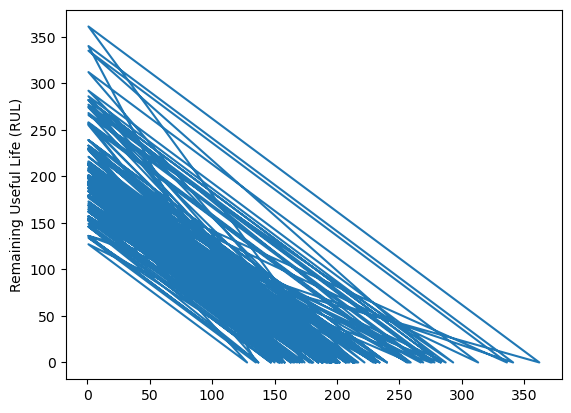

In [8]:
train_unit1 = train
plt.plot(train_unit1['time_cycles'], train_unit1['RUL'])
plt.ylabel('Remaining Useful Life (RUL)')
#test.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

#print(train_unit1)
#plt.plot(rul_by_unit['time_cycles'],rul_by_unit['RUL'])

In [9]:
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(
    X_train.drop('RUL', axis=1), #predictor
    X_train['RUL'], #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
13175  518.67  642.22  1586.82  1402.28  14.62  21.61  553.20  2388.07   
1700   518.67  643.68  1597.92  1429.13  14.62  21.61  551.70  2388.20   
19098  518.67  642.35  1581.19  1409.49  14.62  21.61  553.44  2388.12   
18053  518.67  641.81  1579.99  1396.67  14.62  21.61  554.07  2388.05   
6376   518.67  643.06  1600.69  1417.16  14.62  21.61  552.29  2388.14   
...       ...     ...      ...      ...    ...    ...     ...      ...   
13123  518.67  642.08  1591.25  1395.19  14.62  21.61  554.75  2388.07   
19648  518.67  642.99  1587.87  1404.63  14.62  21.61  554.42  2388.08   
9845   518.67  642.90  1596.24  1410.80  14.62  21.61  552.80  2388.09   
10799  518.67  642.10  1595.20  1401.58  14.62  21.61  553.31  2388.12   
2732   518.67  642.63  1589.49  1412.80  14.62  21.61  553.67  2388.08   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
13175  9069.00   1.3  ...  521

<h1> Building The Pipeline </h1> 

In [10]:
feature_sel_rf = RandomForestRegressor(n_estimators=100, random_state=0)
sfm = SelectFromModel(feature_sel_rf, threshold='median')

In [12]:
rf_fs_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', sfm), 
    ('SVR', SVR(kernel = 'rbf')),
])

In [13]:
rf_fs_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sfm',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0),
                                 threshold='median')),
                ('SVR', SVR())])

In [14]:
selected_features = X_train.columns[sfm.get_support()]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['s_2', 's_3', 's_4', 's_7', 's_9', 's_11', 's_12', 's_14', 's_15',
       's_20', 's_21'],
      dtype='object')


In [15]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [16]:

# Predictions on training set
pred_train = rf_fs_pipe.predict(X_train)

# Evaluate rounded predictions on training set
evaluate(y_train, pred_train, label = "train")


# Predictions on test set
pred_test = rf_fs_pipe.predict(X_test)

# Evaluate rounded predictions on test set
evaluate(y_test, pred_test)

train set RMSE:42.48151569507344, R2:0.6224869024916168, MAE:29.569826159857094
test set RMSE:42.069734107538345, R2:0.6202145894614626, MAE:29.37146567764873


In [17]:
#X_valid = test.drop(columns=drop_labels).copy()
X_valid = test.groupby('unit_number').max().reset_index().drop(columns=drop_labels)
new_pred = rf_fs_pipe.predict(X_valid)
evaluate(rul, new_pred, label = 'valid')

valid set RMSE:32.29518352251725, R2:0.39602916239125996, MAE:28.192811961818755


In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_

# Select features based on importance
sfm = SelectFromModel(rf, threshold='median')
X_train_selected = sfm.fit_transform(X_train, y_train)

# Subset data to include only selected features
selected_features = X_train.columns[sfm.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)

In [ ]:
print(X_train_selected_df)
print(X_train_selected_df.shape)

In [ ]:
regressor = RandomForestRegressor(random_state=0)

In [ ]:
regressor.fit(X_train_selected_df, y_train)

In [ ]:
X_test_selected = sfm.transform(X_test)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)
print(X_test_selected_df)

<h2>Building the pipeline </h2>

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [ ]:
# Predictions on training set
pred_train = regressor.predict(X_train_selected_df)

# Evaluate rounded predictions on training set
evaluate(y_train, pred_train, label = "train")


# Predictions on test set
pred_test = regressor.predict(X_test_selected_df)

# Evaluate rounded predictions on test set
evaluate(y_test, pred_test)


In [ ]:
plt.scatter(pred_train, y_train)

In [ ]:
plt.scatter(pred_test, y_test)

In [ ]:
y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(ML_pipeline.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

<h2> Cross Validation </h2>

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Perform cross-validation on the training set
cv_predictions_train = cross_val_predict(regressor, X_train, y_train, cv=kf)

# Evaluate cross-validated predictions on training set
evaluate(y_train, cv_predictions_train, label='cross-validation on training')

# Fit the pipeline to the entire training set
regressor.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = regressor.predict(X_test)

# Evaluate the model on the test set
evaluate(y_test, test_predictions, label='test')


<h1> Scoring </h1>

In [ ]:
X_valid = test.groupby('unit_number').max().reset_index().drop(columns=drop_labels)
X_valid_selected = sfm.transform(X_valid)
X_valid_selected_df = pd.DataFrame(X_valid_selected, columns=selected_features)

In [ ]:
new_pred = regressor.predict(X_valid)
evaluate(rul, new_pred, label = 'valid')

In [ ]:
plt.scatter(rul, new_pred)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Evaluation of RUL Predictions using RF')

In [ ]:
save_path = "../backend/"

# Fit the pipeline to the entire training set
ML_pipeline.fit(X_train, y_train)

# Serialize the trained model to a file in the specified location
#joblib.dump(ML_pipeline, save_path + 'rf_correlation.pkl')